In [24]:
import os
import sys
import importlib.util
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import joblib
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Dynamically find the project root by looking for the 'data' folder
current_dir = os.getcwd()
project_root = current_dir

# Go up levels until we find the 'data' folder which marks the root
while not os.path.exists(os.path.join(project_root, 'data')):
    project_root = os.path.dirname(project_root)
    if len(project_root) < 3: # Stop if we reach drive root (e.g. C:\)
        raise Exception("Could not find project root. Make sure structure is correct.")

# Define paths correctly
INPUT_FILE = os.path.join(project_root, 'data', 'datasets', 'url_features_dataset.csv')
FEATURE_SCRIPT = os.path.join(project_root, 'src', 'features', 'extract_url_features.py')
MODEL_PATH = os.path.join(project_root, 'src', 'models', 'saved_models', 'url_random_forest.pkl')

print(f"Project Root detected: {project_root}")
print(f"Feature Script: {FEATURE_SCRIPT}")

Project Root detected: d:\project-3
Feature Script: d:\project-3\src\features\extract_url_features.py


In [18]:
if not os.path.exists(FEATURE_SCRIPT):
    print(f"ERROR: File not found at {FEATURE_SCRIPT}")
else:
    spec = importlib.util.spec_from_file_location("extract_module", FEATURE_SCRIPT)
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)
    extract_features = module.extract_features
    print("Success: 'extract_features' function loaded.")

Success: 'extract_features' function loaded.


In [41]:
# List of complex SAFE URLs that model often misclassifies
# These are legitimate URLs with complex structures (subdomains, long paths, query params)
hard_safe_urls = [
    # Google Services
    "https://gemini.google.com/app",
    "https://docs.google.com/document/d/1abc123xyz/edit?usp=sharing",
    "https://drive.google.com/file/d/1234567890/view",
    "https://mail.google.com/mail/u/0/#inbox",
    "https://accounts.google.com/signin/v2/identifier",
    "https://calendar.google.com/calendar/u/0/r",
    "https://meet.google.com/abc-defg-hij",
    "https://cloud.google.com/products/compute",
    "https://console.cloud.google.com/home/dashboard",
    "https://play.google.com/store/apps/details?id=com.example",
    "https://news.google.com/topstories?hl=en",
    "https://translate.google.com/?sl=en&tl=vi",
    "https://maps.google.com/maps?q=hanoi",
    "https://photos.google.com/album/abc123",
    "https://colab.research.google.com/drive/1xyz",
    
    # Microsoft Services  
    "https://portal.azure.com/#create/Microsoft.VirtualMachine",
    "https://outlook.live.com/mail/0/inbox",
    "https://onedrive.live.com/?id=root",
    "https://login.microsoftonline.com/common/oauth2/authorize",
    "https://teams.microsoft.com/_#/conversations",
    "https://office.com/launch/word",
    "https://sharepoint.com/sites/company",
    "https://visualstudio.microsoft.com/downloads/",
    "https://learn.microsoft.com/en-us/docs",
    "https://dev.azure.com/organization/project",
    
    # Amazon Services
    "https://www.amazon.com/dp/B09G9FPHY6/ref=cm_sw_r",
    "https://aws.amazon.com/console/",
    "https://console.aws.amazon.com/ec2/v2/home",
    "https://s3.console.aws.amazon.com/s3/buckets",
    "https://signin.aws.amazon.com/signin",
    "https://prime.amazon.com/",
    "https://music.amazon.com/albums/B08XYZ",
    
    # Social Media & Entertainment
    "https://www.facebook.com/profile.php?id=100000",
    "https://m.facebook.com/login/?next=https%3A%2F%2Fm.facebook.com",
    "https://www.instagram.com/accounts/login/",
    "https://twitter.com/i/flow/login",
    "https://x.com/home",
    "https://www.linkedin.com/in/username/",
    "https://www.youtube.com/watch?v=dQw4w9WgXcQ&list=PLxyz",
    "https://studio.youtube.com/channel/UCxyz",
    "https://www.tiktok.com/@username/video/1234567890",
    "https://www.reddit.com/r/programming/comments/abc123",
    "https://discord.com/channels/123456789/987654321",
    "https://www.netflix.com/watch/80186799",
    "https://open.spotify.com/track/4iV5W9uYEdYUVa79Axb7Rh",
    
    # Developer & Tech
    "https://github.com/microsoft/vscode/blob/main/README.md",
    "https://stackoverflow.com/questions/12345678/how-to-fix",
    "https://gitlab.com/user/repo/-/merge_requests/1",
    "https://bitbucket.org/workspace/repo/src/main/",
    "https://npmjs.com/package/react",
    "https://pypi.org/project/tensorflow/",
    "https://hub.docker.com/_/python",
    "https://vercel.com/dashboard",
    "https://app.netlify.com/sites/mysite",
    "https://heroku.com/apps/myapp",
    "https://railway.app/project/abc123",
    
    # Finance & Business (legitimate)
    "https://www.paypal.com/myaccount/summary",
    "https://www.chase.com/personal/checking",
    "https://www.bankofamerica.com/online-banking/",
    "https://www.wellsfargo.com/biz/",
    "https://www.vanguard.com/us/LogonEmailAddress",
    "https://robinhood.com/account",
    
    # E-commerce & Services
    "https://www.ebay.com/itm/123456789012",
    "https://www.etsy.com/listing/1234567890",
    "https://www.alibaba.com/product-detail/xyz",
    "https://www.shopify.com/admin",
    "https://www.wordpress.com/post/mysite/123",
    "https://medium.com/@author/article-title-abc123",
    "https://www.notion.so/workspace/page-id",
    "https://trello.com/b/abc123/board-name",
    "https://slack.com/workspace/messages/channel",
    "https://zoom.us/j/1234567890?pwd=xyz",
    
    # Education & Reference
    "https://www.coursera.org/learn/machine-learning",
    "https://www.udemy.com/course/python-bootcamp/",
    "https://www.khanacademy.org/computing/computer-science",
    "https://en.wikipedia.org/wiki/Phishing",
    "https://scholar.google.com/citations?user=xyz",
    
    # Vietnamese sites
    "https://vnexpress.net/kinh-doanh",
    "https://shopee.vn/product/123456789",
    "https://tiki.vn/san-pham/abc-p12345",
    "https://lazada.vn/products/xyz-i123456.html",
    "https://momo.vn/payment",
    "https://vietcombank.com.vn/",
    "https://techcombank.com.vn/personal"
]

# Create DataFrame with safe label
df_hard = pd.DataFrame({'url': hard_safe_urls, 'label': 0})
print(f"Added {len(hard_safe_urls)} complex safe URLs to training data")

Added 84 complex safe URLs to training data


In [42]:
# Load original data
df_original = pd.read_csv(INPUT_FILE)

# Calculate features for hard samples
print("Extracting features for hard samples...")
df_hard_features = extract_features(df_hard)

# Merge datasets
df_final = pd.concat([df_original, df_hard_features], ignore_index=True).fillna(0)
print(f"Total samples: {len(df_final)}")

Extracting features for hard samples...
Extracting features for 84 URLs...
Total samples: 2089


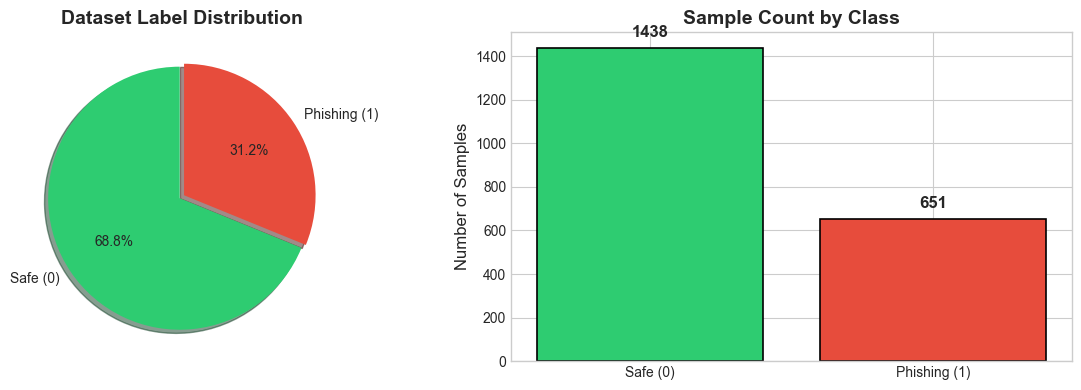

Total samples: 2089
Safe: 651 | Phishing: 1438


In [43]:
# --- Dataset Distribution Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Pie chart - Label distribution
label_counts = df_final['label'].value_counts()
labels = ['Safe (0)', 'Phishing (1)']
colors = ['#2ecc71', '#e74c3c']

axes[0].pie(label_counts, labels=labels, autopct='%1.1f%%', colors=colors, 
            explode=(0.02, 0.02), shadow=True, startangle=90)
axes[0].set_title('Dataset Label Distribution', fontsize=14, fontweight='bold')

# Bar chart
bars = axes[1].bar(labels, label_counts.values, color=colors, edgecolor='black', linewidth=1.2)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_title('Sample Count by Class', fontsize=14, fontweight='bold')
for bar, count in zip(bars, label_counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                 str(count), ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Total samples: {len(df_final)}")
print(f"Safe: {label_counts[0]} | Phishing: {label_counts[1]}")

In [44]:
X = df_final.drop(['url', 'label'], axis=1)
y = df_final['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Train size: {X_train.shape[0]}, Test size: {X_test.shape[0]}")

Train size: 1671, Test size: 418


In [45]:
# Limit depth to prevent overfitting (100% accuracy issue)
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10, 
    min_samples_leaf=3,
    class_weight='balanced',
    random_state=42
)

rf_model.fit(X_train, y_train)
print("Training completed.")

Training completed.


OVERFITTING CHECK
Train Accuracy: 97.85%
Test Accuracy:  98.56%
Gap:            -0.72%


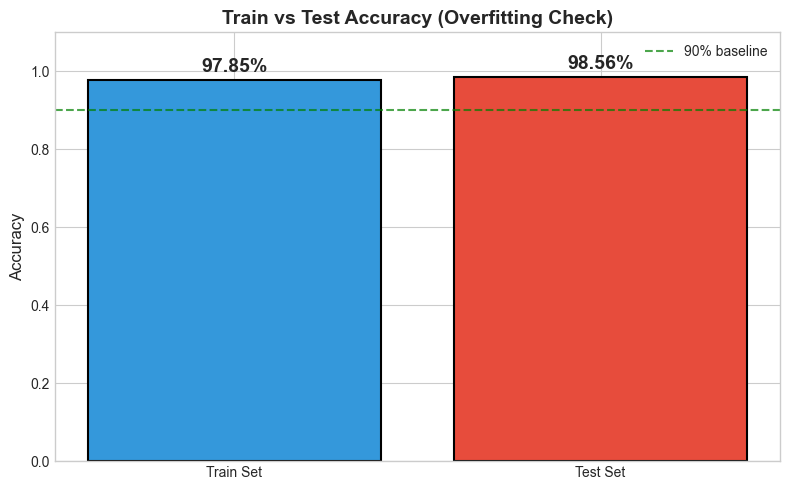


[OK] NO SIGNIFICANT OVERFITTING.
  -> Train and test accuracies are close. Model generalizes well.

Model saved to: d:\project-3\src\models\saved_models\url_random_forest.pkl


In [46]:
# --- Evaluate & Check Overfitting ---
train_acc = accuracy_score(y_train, rf_model.predict(X_train))
test_acc = accuracy_score(y_test, rf_model.predict(X_test))
acc = test_acc  # for later use

print("=" * 50)
print("OVERFITTING CHECK")
print("=" * 50)
print(f"Train Accuracy: {train_acc * 100:.2f}%")
print(f"Test Accuracy:  {test_acc * 100:.2f}%")
print(f"Gap:            {(train_acc - test_acc) * 100:.2f}%")
print("=" * 50)

# Visualize comparison
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(['Train Set', 'Test Set'], [train_acc, test_acc], 
              color=['#3498db', '#e74c3c'], edgecolor='black', linewidth=1.5)
ax.set_ylim(0, 1.1)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Train vs Test Accuracy (Overfitting Check)', fontsize=14, fontweight='bold')

for bar, val in zip(bars, [train_acc, test_acc]):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{val:.2%}', ha='center', fontsize=14, fontweight='bold')

ax.axhline(y=0.9, color='green', linestyle='--', alpha=0.7, label='90% baseline')
ax.legend()
plt.tight_layout()
plt.show()

# Verdict
gap = train_acc - test_acc
if gap > 0.10:
    print("\n[WARNING] HIGH OVERFITTING DETECTED!")
    print("  -> Train accuracy is significantly higher than test accuracy.")
    print("  -> Consider: reduce max_depth, increase min_samples_leaf, or get more data.")
elif gap > 0.05:
    print("\n[CAUTION] SLIGHT OVERFITTING detected.")
    print("  -> Model may not generalize perfectly to new data.")
else:
    print("\n[OK] NO SIGNIFICANT OVERFITTING.")
    print("  -> Train and test accuracies are close. Model generalizes well.")

# Save model
joblib.dump(rf_model, MODEL_PATH)
print(f"\nModel saved to: {MODEL_PATH}")

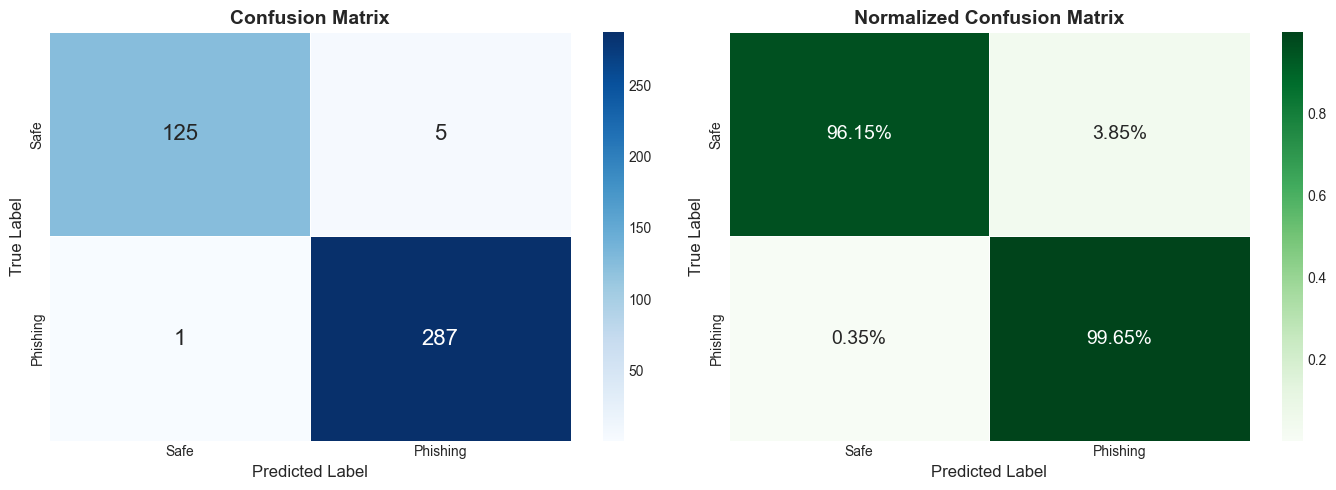

In [47]:
# --- Confusion Matrix ---
y_pred = rf_model.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Safe', 'Phishing'], yticklabels=['Safe', 'Phishing'],
            annot_kws={'size': 16}, linewidths=0.5)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

# Normalized Confusion Matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Greens', ax=axes[1],
            xticklabels=['Safe', 'Phishing'], yticklabels=['Safe', 'Phishing'],
            annot_kws={'size': 14}, linewidths=0.5)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

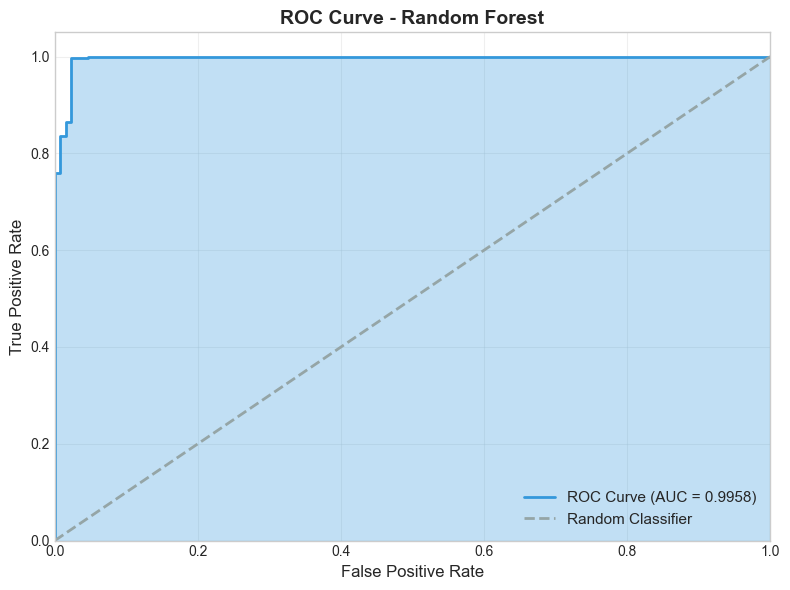

AUC Score: 0.9958


In [48]:
# --- ROC Curve ---
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='#3498db', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='#95a5a6', lw=2, linestyle='--', label='Random Classifier')
plt.fill_between(fpr, tpr, alpha=0.3, color='#3498db')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Random Forest', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

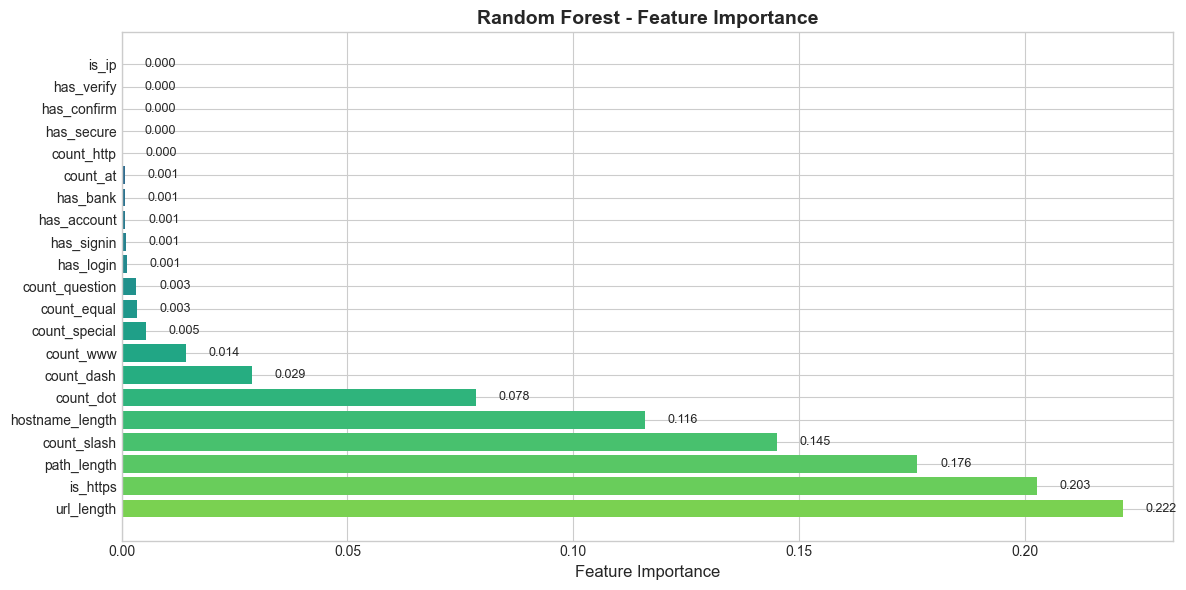


Top 5 Most Important Features:
  1. url_length: 0.2217
  2. is_https: 0.2026
  3. path_length: 0.1762
  4. count_slash: 0.1451
  5. hostname_length: 0.1158


In [49]:
# --- Feature Importance ---
feature_names = X.columns.tolist()
importances = rf_model.feature_importances_

# Sort by importance
indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

plt.figure(figsize=(12, 6))
bars = plt.barh(range(len(sorted_features)), sorted_importances[::-1], 
                color=plt.cm.viridis(np.linspace(0.2, 0.8, len(sorted_features))))
plt.yticks(range(len(sorted_features)), sorted_features[::-1], fontsize=10)
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Random Forest - Feature Importance', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add values on bars
for i, (bar, imp) in enumerate(zip(bars, sorted_importances[::-1])):
    plt.text(imp + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{imp:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\nTop 5 Most Important Features:")
for i in range(5):
    print(f"  {i+1}. {sorted_features[i]}: {sorted_importances[i]:.4f}")

CLASSIFICATION REPORT
              precision    recall  f1-score   support

        Safe       0.99      0.96      0.98       130
    Phishing       0.98      1.00      0.99       288

    accuracy                           0.99       418
   macro avg       0.99      0.98      0.98       418
weighted avg       0.99      0.99      0.99       418



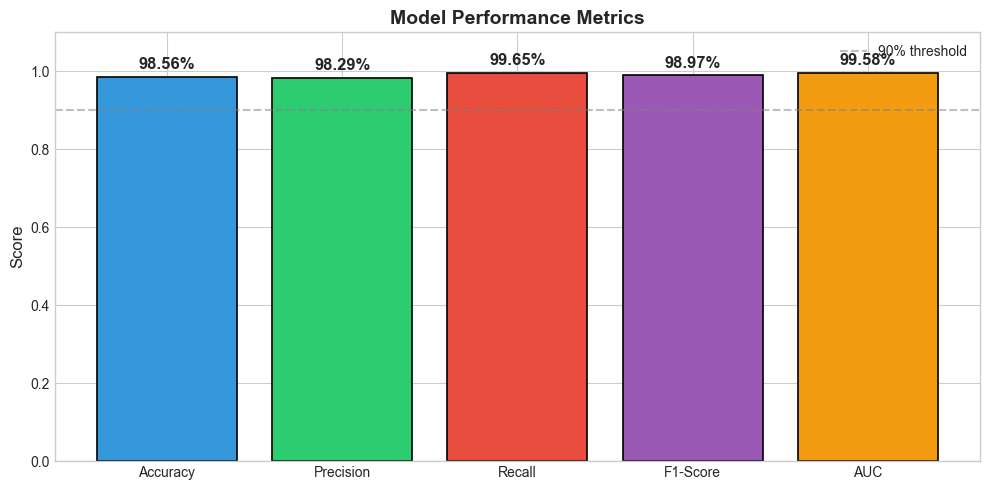

In [40]:
# --- Classification Report ---
print("=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['Safe', 'Phishing']))

# Metrics Summary
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
values = [acc, precision, recall, f1, roc_auc]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']

plt.figure(figsize=(10, 5))
bars = plt.bar(metrics, values, color=colors, edgecolor='black', linewidth=1.2)
plt.ylim(0, 1.1)
plt.ylabel('Score', fontsize=12)
plt.title('Model Performance Metrics', fontsize=14, fontweight='bold')

for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.2%}', ha='center', fontsize=12, fontweight='bold')

plt.axhline(y=0.9, color='gray', linestyle='--', alpha=0.5, label='90% threshold')
plt.legend()
plt.tight_layout()
plt.show()